<h1>Part B - Classify player position</h1>

<h3>**Can a professional defender become a forward?
Train on data from FIFA 19. Predict the player_position variable using other skill statistics for players in the FIFA 20 Edition. Train on all players from FIFA 19**</h3>

**Graphically represent the predicted player_position for the players in Test Set** 

**Details : **

>Sofifa Id, URL, Wage, Salary, Name, Real face, URL variables cannot be used during the prediction or learning. *

>The final score will be assigned using Classification accuracy

>Test Set: Players from the following Clubs 

>FC Barcelona

>FC Bayern München

>Real Madrid 

>Paris Saint-Germain

>Juventus

>Atlético Madrid

>Manchester City

>Liverpool 

>Manchester United

Importing important Libraries and Packages

In [244]:
#import important libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OutputCodeClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf


Reading the FIFA 19 and 20 dataset

In [192]:
#read the csv files and have a look at all the columns
df_trn = pd.read_csv('players_19.csv')
df_tst = pd.read_csv('players_20.csv')
pd.set_option('display.max_columns', None)
clubs = ['Real Madrid', 'FC Barcelona', 'FC Bayern München', 'Paris Saint-Germain', 'Juventus', 'Atlético Madrid', 'Manchester City', 'Liverpool', 'Manchester United']
df_trn.head()

(17770, 104)


,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33,1985-02-05,187,83,Portugal,Juventus,94,94,77000000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,127100000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,81.0,89.0,35.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Diver, Flair, Long Shot Taker...",84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,31,1987-06-24,170,72,Argentina,FC Barcelona,94,94,110500000,565000,"CF, RW, ST",Left,5,4,4,Medium/Medium,Messi,Yes,226500000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",RW,10.0,NaN,2004-07-01,2021.0,CF,10.0,88.0,91.0,88.0,96.0,32.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (CPU AI Only), S...",77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,90+2,84+2,84+2,84+2,90+2,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,26,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,93,118500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,228100000.0,"#Speedster, #Dribbler, #FK Specialist, #Acroba...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,92.0,84.0,83.0,95.0,32.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,"Diver, Selfish, Flair, Speed Dribbler (CPU AI ...",79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3
3,193080,https://sofifa.com/player/193080/david-de-gea-...,De Gea,David De Gea Quintana,27,1990-11-07,193,76,Spain,Manchester United,91,93,72000000,260000,GK,Right,4,3,1,Medium/Medium,Lean,Yes,138600000.0,NaN,GK,1.0,NaN,2011-07-01,2019.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,85.0,87.0,94.0,58.0,88.0,"GK Long Throw, Saves with Feet",17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,27,1991-06-28,181,70,Belgium,Manchester City,91,92,102000000,355000,"CAM, CM",Right,4,5,4,High/High,Normal,Yes,196400000.0,"#Dribbler, #Playmaker , #Eng

Defining Some Helper Functions for data processing

In [193]:
#define a function that gets one-hot-encoded column and deletes th previous column
def one_hot_encode(df,column):
    vals = pd.get_dummies(df[column])
    df = df.drop(column,axis=1)
    df = pd.concat((df,vals),axis=1)
    return df

def get_bmi(df):
    h = df['height_cm']/100
    w = df['weight_kg']
    bmi = w/h**2
    df = df.drop(['height_cm','weight_kg'],axis=1)
    bmi = pd.DataFrame(bmi,columns=['bmi'])
    df = pd.concat([df,bmi],axis=1)
    return df

Dropping the useess columns. Some columns which are dropped currently could be of use in future, they are listed in commnents

In [194]:
#Drop useless columns from both the datasets, some columns which were dropped but could be used to improve accuracy are :
#player_tags,player_traits,joined,nation_position,nation_jersey_number,team_jersey_number

useless = ['sofifa_id','player_url','short_name','long_name','dob','wage_eur','body_type','real_face','nationality','club','player_tags','body_type','player_traits','joined','nation_position','loaned_from','nation_jersey_number','team_jersey_number']
df_train = df_trn.drop(useless,axis=1)
df_test = df_tst.drop(useless,axis=1)
df_train.head()

,age,height_cm,weight_kg,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,release_clause_eur,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,33,187,83,94,94,77000000,"ST, LW",Right,5,4,5,High/Low,127100000.0,LW,2022.0,90.0,93.0,81.0,89.0,35.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
1,31,170,72,94,94,110500000,"CF, RW, ST",Left,5,4,4,Medium/Medium,226500000.0,RW,2021.0,88.0,91.0,88.0,96.0,32.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,90+2,84+2,84+2,84+2,90+2,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2
2,26,175,68,92,93,118500000,"LW, CAM",Right,5,5,5,High/Medium,228100000.0,CAM,2022.0,92.0,84.0,83.0,95.0,32.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3
3,27,193,76,91,93,72000000,GK,Right,4,3,1,Medium/Medium,138600000.0,GK,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,85.0,87.0,94.0,58.0,88.0,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27,181,70,91,92,102000000,"CAM, CM",Right,4,5,4,High/High,196400000.0,RCM,2023.0,77.0,86.0,92.0,87.0,60.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3


Team Position should be a good predictor for player position but due to too many NaN entries and a large variety
it becomes difficult to deal with, hence we will drop it later. But replacing NaN with a dummy position 'anywhere' is the part 
pre-processing currently

In [195]:
#Deat with NaN entries in team_position column
df_train['team_position'].fillna('Anywhere',inplace=True)
df_train['release_clause_eur'].fillna(1000)
df_test['release_clause_eur'].fillna(1000)
print(df_train['team_position'].isnull().sum())
print(df_train['work_rate'].isnull().sum())

0
0


Now we call on the helper functions and one-hot-encode the columns we though are usefu and have a reasonable variety of entries.
We also combine height and weight into a new column BMI

In [196]:
#Call previous function to one-hot-encode work_rate column
df_train = one_hot_encode(df_train,'work_rate')
df_train = get_bmi(df_train)
df_test = one_hot_encode(df_test,'work_rate')
df_test = get_bmi(df_test)
#df_train = df_train.drop('work_rate',axis=1)
#df_test = df_test.drop('work_rate',axis=1)
df_train.head()

,age,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,release_clause_eur,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,High/High,High/Low,High/Medium,Low/High,Low/Low,Low/Medium,Medium/High,Medium/Low,Medium/Medium,bmi
0,33,94,94,77000000,"ST, LW",Right,5,4,5,127100000.0,LW,2022.0,90.0,93.0,81.0,89.0,35.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,0,1,0,0,0,0,0,0,0,23.735308
1,31,94,94,110500000,"CF, RW, ST",Left,5,4,4,226500000.0,RW,2021.0,88.0,91.0,88.0,96.0,32.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,90+2,84+2,84+2,84+2,90+2,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2,0,0,0,0,0,0,0,0,1,24.913495
2,26,92,93,118500000,"LW, CAM",Right,5,5,5,228100000.0,CAM,2022.0,92.0,84.0,83.0,95.0,32.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,0,0,1,0,0,0,0,0,0,22.204082
3,27,91,93,72000000,GK,Right,4,3,1,138600000.0,GK,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,85.0,87.0,94.0,58.0,88.0,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,20.403232
4,27,91,92,102000000,"CAM, CM",Right,4,5,4,196400000.0,RCM,2023.0,77.0,86.0,92.0,87.0,60.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,1,0,0,0,0,0,0,0,0,21.366869


For the columns listed below the entry is of the form '87+3'. We need to make it into a form which can be interpreted as
an integer, hence'87' will be extracted. We also binary encode right and left in the preferred_foot column

In [197]:
#These columns have some entries of th type '87+3', extract ony the first part from these
columns = ['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm', 'cdm','rdm','rwb','lb','lcb','cb','rcb','rb']
for col in columns:
    df_train[col]=df_train[col].str.split('+',n=1,expand = True)[0]
    df_test[col]=df_test[col].str.split('+',n=1,expand = True)[0]
df_train['preferred_foot'] = df_train['preferred_foot'].replace(['Right','Left'],[1,0])
df_test['preferred_foot'] = df_test['preferred_foot'].replace(['Right','Left'],[1,0])
df_train.head()

,age,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,release_clause_eur,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,High/High,High/Low,High/Medium,Low/High,Low/Low,Low/Medium,Medium/High,Medium/Low,Medium/Medium,bmi
0,33,94,94,77000000,"ST, LW",1,5,4,5,127100000.0,LW,2022.0,90.0,93.0,81.0,89.0,35.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,0,1,0,0,0,0,0,0,0,23.735308
1,31,94,94,110500000,"CF, RW, ST",0,5,4,4,226500000.0,RW,2021.0,88.0,91.0,88.0,96.0,32.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88,88,88,92,93,93,93,92,93,93,93,90,84,84,84,90,63,61,61,61,63,58,47,47,47,58,0,0,0,0,0,0,0,0,1,24.913495
2,26,92,93,118500000,"LW, CAM",1,5,5,5,228100000.0,CAM,2022.0,92.0,84.0,83.0,95.0,32.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,0,0,1,0,0,0,0,0,0,22.204082
3,27,91,93,72000000,GK,1,4,3,1,138600000.0,GK,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,85.0,87.0,94.0,58.0,88.0,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,20.403232
4,27,91,92,102000000,"CAM, CM",1,4,5,4,196400000.0,RCM,2023.0,77.0,86.0,92.0,87.0,60.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,1,0,0,0,0,0,0,0,0,21.366869


The entries in these columns like the previous ones have entries of type '87-3' and '56+3'.
And we extract the first parts of these entires here.

In [198]:
#These columns have entries of the type '87-3' and '56+3'. Extract only the first part of these
columns = ['attacking_crossing','attacking_finishing','attacking_heading_accuracy','attacking_short_passing','attacking_volleys','skill_dribbling','skill_curve','skill_fk_accuracy','skill_long_passing','skill_ball_control','movement_acceleration','movement_sprint_speed','movement_agility','movement_reactions','movement_balance','power_shot_power','power_jumping','power_stamina','power_strength','power_long_shots','mentality_aggression','mentality_interceptions','mentality_positioning','mentality_vision','mentality_penalties','mentality_composure','defending_marking','defending_standing_tackle','defending_sliding_tackle','goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning','goalkeeping_reflexes']
for col in columns:
    df_train[col] = df_train[col].str.replace('-','+')
    df_train[col]=df_train[col].str.split('+',n=1,expand = True)[0]
df_train.head()

,age,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,release_clause_eur,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,High/High,High/Low,High/Medium,Low/High,Low/Low,Low/Medium,Medium/High,Medium/Low,Medium/Medium,bmi
0,33,94,94,77000000,"ST, LW",1,5,4,5,127100000.0,LW,2022.0,90.0,93.0,81.0,89.0,35.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,0,1,0,0,0,0,0,0,0,23.735308
1,31,94,94,110500000,"CF, RW, ST",0,5,4,4,226500000.0,RW,2021.0,88.0,91.0,88.0,96.0,32.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88,88,88,92,93,93,93,92,93,93,93,90,84,84,84,90,63,61,61,61,63,58,47,47,47,58,0,0,0,0,0,0,0,0,1,24.913495
2,26,92,93,118500000,"LW, CAM",1,5,5,5,228100000.0,CAM,2022.0,92.0,84.0,83.0,95.0,32.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,0,0,1,0,0,0,0,0,0,22.204082
3,27,91,93,72000000,GK,1,4,3,1,138600000.0,GK,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,85.0,87.0,94.0,58.0,88.0,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,20.403232
4,27,91,92,102000000,"CAM, CM",1,4,5,4,196400000.0,RCM,2023.0,77.0,86.0,92.0,87.0,60.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,1,0,0,0,0,0,0,0,0,21.366869


GK are usually not assigned any value for the columns listed below. Hence they are read as NaN. We cannot replace NaN here with 0 as GK do not have 0 of these skills/stats. The minimum entry in each column was the same - 31. Hence GKs were assigned a value of 30 or less than 30 depending on the accuracy the value gives.

In [209]:
#Deal with NaN entries in these columns. Tried multiple things instead of justfilling NaN with 0
columns = ['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm', 'cdm','rdm','rwb','lb','lcb','cb','rcb','rb']
df_train[columns] = df_train[columns].fillna(20)
df_train[columns] = df_train[columns].astype(int)
columns = ['dribbling','defending','physic','passing','shooting','pace']
#df_train[columns] = df_train[columns].fillna(0)
for col in columns:
    df_train[col] = df_train[col].fillna(df_train[col].median())
df_train['contract_valid_until'] = df_train['contract_valid_until'].fillna(df_train['contract_valid_until'].max())
df_train[columns] = df_train[columns].astype(int)
df_train = df_train.fillna(0)
#df_train.isnull().sum()

Single player can have multiple player positions, but the exercise is to assign a single position to a player. Hence just one entry was maintained.

In [210]:
#Multiple player positions are present for a single player, extract only one out of those
df_train['player_positions'] = df_train['player_positions'].str.split(',',n=1,expand=True)[0]
df_train.head()

,age,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,release_clause_eur,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,High/High,High/Low,High/Medium,Low/High,Low/Low,Low/Medium,Medium/High,Medium/Low,Medium/Medium,bmi
0,33,94,94,77000000,ST,1,5,4,5,127100000.0,LW,2022.0,90,93,81,89,35,79,0.0,0.0,0.0,0.0,0.0,0.0,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,0,1,0,0,0,0,0,0,0,23.735308
1,31,94,94,110500000,CF,0,5,4,4,226500000.0,RW,2021.0,88,91,88,96,32,61,0.0,0.0,0.0,0.0,0.0,0.0,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88,88,88,92,93,93,93,92,93,93,93,90,84,84,84,90,63,61,61,61,63,58,47,47,47,58,0,0,0,0,0,0,0,0,1,24.913495
2,26,92,93,118500000,LW,1,5,5,5,228100000.0,CAM,2022.0,92,84,83,95,32,59,0.0,0.0,0.0,0.0,0.0,0.0,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,0,0,1,0,0,0,0,0,0,22.204082
3,27,91,93,72000000,GK,1,4,3,1,138600000.0,GK,2019.0,69,54,58,64,56,66,90.0,85.0,87.0,94.0,58.0,88.0,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,0,0,0,0,0,0,0,0,1,20.403232
4,27,91,92,102000000,CAM,1,4,5,4,196400000.0,RCM,2023.0,77,86,92,87,60,78,0.0,0.0,0.0,0.0,0.0,0.0,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,1,0,0,0,0,0,0,0,0,21.366869


Predictor variable and Response variable are separated. The predictor is normalised or standardised according to performance generated by each method

In [211]:
#Separating the predictor and response variables
y = df_train['player_positions']
y_nn = pd.get_dummies(y)
Xt = df_train.drop('player_positions',axis=1)
X_n = Xt.drop('team_position',axis=1)
X_norm = MinMaxScaler().fit_transform(X_n)
X_std = StandardScaler().fit_transform(X_n)
X = pd.DataFrame(X_std, index=X_n.index, columns=X_n.columns)
#X = pd.concat([X,Xt['team_position']],axis=1)
print(X.shape,y.shape)

(17770, 92) (17770,)


Trying out Logistic Regression for Classification. 

In [238]:
#Defining model and fitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8, random_state = 66)

model = LogisticRegression(max_iter=1e4, C=0.01, random_state=0)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)


validation_accuracy = accuracy_score(y_val, y_val_pred)
#model = OutputCodeClassifier(LogisticRegression(max_iter=10000,random_state=0,C=10000),code_size=1.5)
#model.fit(X,y)
#y_pred = model.predict(X)


In [239]:
#Getting training accuracy
#acc = accuracy_score(y,y_pred)
print('Validation Accuracy : ',validation_accuracy)

Validation Accuracy :  0.7495779403489027


Cleaning up test set in accordance to the train set and getting test accuracy

In [240]:
columns = ['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm', 'cdm','rdm','rwb','lb','lcb','cb','rcb','rb']
df_test[columns] = df_test[columns].fillna(30)
df_test[columns] = df_test[columns].astype(int)
columns = ['dribbling','defending','physic','passing','shooting','pace']

for col in columns:
    df_test[col] = df_test[col].fillna(df_test[col].median())
df_test[columns] = df_test[columns].astype(int)
df_test['contract_valid_until'] = df_test['contract_valid_until'].fillna(df_test['contract_valid_until'].max())
df_test = df_test.fillna(0)
df_test['player_positions'] = df_test['player_positions'].str.split(',',n=1,expand=True)[0]
df_test.head()

,age,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,release_clause_eur,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,High/High,High/Low,High/Medium,Low/High,Low/Low,Low/Medium,Medium/High,Medium/Low,Medium/Medium,bmi
0,32,94,94,95500000,RW,0,5,4,4,195800000.0,RW,2021.0,87,92,92,96,39,66,0.0,0.0,0.0,0.0,0.0,0.0,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89,89,89,93,93,93,93,93,93,93,93,92,87,87,87,92,68,66,66,66,68,63,52,52,52,63,0,0,0,0,0,0,0,1,0,24.913495
1,34,93,93,58500000,ST,1,5,4,5,96500000.0,LW,2022.0,90,93,82,89,35,78,0.0,0.0,0.0,0.0,0.0,0.0,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,0,1,0,0,0,0,0,0,0,23.735308
2,27,92,92,105500000,LW,1,5,5,5,195200000.0,CAM,2022.0,91,85,87,95,32,58,0.0,0.0,0.0,0.0,0.0,0.0,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84,84,84,90,89,89,89,90,90,90,90,89,82,82,82,89,66,61,61,61,66,61,46,46,46,61,0,0,1,0,0,0,0,0,0,22.204082
3,26,91,93,77500000,GK,1,3,3,1,164700000.0,GK,2023.0,69,54,58,64,56,66,87.0,92.0,78.0,89.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,0,0,0,0,0,0,0,0,1,24.615211
4,28,91,91,90000000,LW,1,4,4,4,184500000.0,LW,2024.0,91,83,86,94,35,66,0.0,0.0,0.0,0.0,0.0,0.0,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83,83,83,89,88,88,88,89,89,89,89,89,83,83,83,89,66,63,63,63,66,61,49,49,49,61,0,0,1,0,0,0,0,0,0,24.163265


In [241]:
y_test = df_test['player_positions']
y_test = y_test[df_tst['club'].isin(clubs)]
X_tst = df_test.drop(['player_positions','team_position'],axis=1)
X_test = X_tst[df_tst['club'].isin(clubs)]
X_test = StandardScaler().fit_transform(X_test)
X_tst = StandardScaler().fit_transform(X_tst)
y_pred_test = model.predict(X_test)
y_pred_t = model.predict(X_tst)
test_acc = accuracy_score(y_test,y_pred_test)
print('Test set accuracy: ',test_acc)

0.7735191637630662


Understanding the results visually through a bar plot

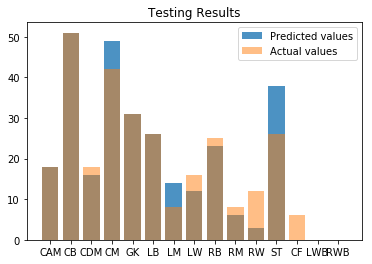

In [242]:
pos_dum = pd.get_dummies(y_pred_t)
pos_pred = pos_dum[df_tst['club'].isin(clubs)].sum(axis=0)
pos_ac = pd.get_dummies(df_test['player_positions'])
pos_actual = pos_ac[df_tst['club'].isin(clubs)].sum(axis=0)
plt.bar(pos_dum.columns,pos_pred,alpha=0.8,label='Predicted values')
plt.bar(pos_ac.columns,pos_actual,alpha=0.5,label='Actual values')
plt.title("Testing Results")
plt.xlabel('Position')
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
pos_pre = pd.get_dummies(y_pred)
pos_pred = pos_pre.sum(axis=0)
pos_actual = y_nn.sum(axis=0)
plt.bar(pos_pre.columns,pos_pred,alpha=0.8,label='Predicted values')
plt.bar(pos_pre.columns,pos_actual[pos_pre.columns],alpha=0.5,label='Actual values')
plt.title("Training Results")
plt.xlabel('Position')
plt.ylabel('Count')
plt.legend()
plt.show()
pd.get_dummies(y_pred).columns

C:\Users\Joy Parikh\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\Joy Parikh\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


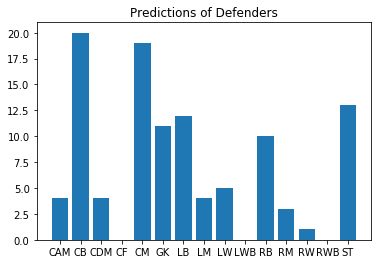

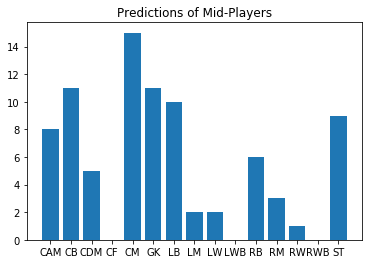

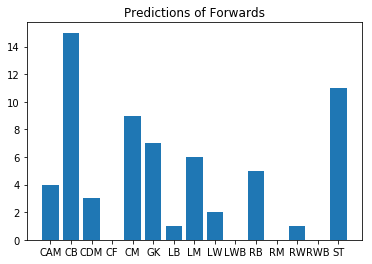

In [245]:
defenders = ['CB','CDM','LB','LWB','RB','RWB']
mid = ['CAM','CM','LM','RM']
forward = ['CF','LW','RW','ST']
y_test_nn = pd.get_dummies(df_test['player_positions'])
y_test_nn = y_test_nn[df_tst['club'].isin(clubs)]
y_nn = pd.get_dummies(df_train['player_positions'])
y_nn = y_nn[df_tst['club'].isin(clubs)]
y_19_actual = y_nn[df_tst['club'].isin(clubs)]
y_20_actual = y_test_nn
y_20_pr = pd.get_dummies(y_pred_t)
y_20_pre = y_20_pr[df_tst['club'].isin(clubs)]
y_20_pred = pd.DataFrame(y_20_pre, index=y_20_actual.index, columns=y_20_actual.columns)
pred_def = y_20_pred[(y_19_actual['CB'] == 1) | (y_19_actual['CDM'] == 1) | (y_19_actual['LB'] == 1) | (y_19_actual['LWB'] == 1)
                    | (y_19_actual['RB'] == 1) | (y_19_actual['RWB'] == 1)].sum(axis=0)
pred_mid = y_20_pred[(y_19_actual['CAM'] == 1) | (y_19_actual['CM'] == 1) | (y_19_actual['RM'] == 1) 
                    | (y_19_actual['LM'] == 1)].sum(axis=0)
pred_for = y_20_pred[(y_19_actual['CF'] == 1) | (y_19_actual['LW'] == 1) | (y_19_actual['RW'] == 1) 
                    | (y_19_actual['ST'] == 1)].sum(axis=0)
plt.figure()
plt.bar(y_nn.columns,pred_def)
plt.title('Predictions of Defenders')
plt.xlabel('Position')
plt.ylabel('Count')
plt.figure()
plt.bar(y_nn.columns,pred_mid)
plt.title('Predictions of Mid-Players')
plt.xlabel('Position')
plt.ylabel('Count')
plt.figure()
plt.bar(y_nn.columns,pred_for)
plt.title('Predictions of Forwards')
plt.xlabel('Position')
plt.ylabel('Count')
plt.show()

Trying out the tuned K-Neighbors Classifier

In [268]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8, random_state = 66)

model = KNeighborsClassifier(22)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)


validation_accuracy = accuracy_score(y_val, y_val_pred)

In [269]:
print('Validation Accuracy : ',validation_accuracy)

Validation Accuracy :  0.6918964546989308


Cleaning up test set in accordance to the train set and getting test accuracy

In [270]:
columns = ['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm', 'cdm','rdm','rwb','lb','lcb','cb','rcb','rb']
df_test[columns] = df_test[columns].fillna(30)
df_test[columns] = df_test[columns].astype(int)
columns = ['dribbling','defending','physic','passing','shooting','pace']

for col in columns:
    df_test[col] = df_test[col].fillna(df_test[col].median())
df_test[columns] = df_test[columns].astype(int)
df_test['contract_valid_until'] = df_test['contract_valid_until'].fillna(df_test['contract_valid_until'].max())
df_test = df_test.fillna(0)
df_test['player_positions'] = df_test['player_positions'].str.split(',',n=1,expand=True)[0]
df_test.head()

,age,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,release_clause_eur,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,High/High,High/Low,High/Medium,Low/High,Low/Low,Low/Medium,Medium/High,Medium/Low,Medium/Medium,bmi
0,32,94,94,95500000,RW,0,5,4,4,195800000.0,RW,2021.0,87,92,92,96,39,66,0.0,0.0,0.0,0.0,0.0,0.0,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89,89,89,93,93,93,93,93,93,93,93,92,87,87,87,92,68,66,66,66,68,63,52,52,52,63,0,0,0,0,0,0,0,1,0,24.913495
1,34,93,93,58500000,ST,1,5,4,5,96500000.0,LW,2022.0,90,93,82,89,35,78,0.0,0.0,0.0,0.0,0.0,0.0,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,0,1,0,0,0,0,0,0,0,23.735308
2,27,92,92,105500000,LW,1,5,5,5,195200000.0,CAM,2022.0,91,85,87,95,32,58,0.0,0.0,0.0,0.0,0.0,0.0,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84,84,84,90,89,89,89,90,90,90,90,89,82,82,82,89,66,61,61,61,66,61,46,46,46,61,0,0,1,0,0,0,0,0,0,22.204082
3,26,91,93,77500000,GK,1,3,3,1,164700000.0,GK,2023.0,69,54,58,64,56,66,87.0,92.0,78.0,89.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,0,0,0,0,0,0,0,0,1,24.615211
4,28,91,91,90000000,LW,1,4,4,4,184500000.0,LW,2024.0,91,83,86,94,35,66,0.0,0.0,0.0,0.0,0.0,0.0,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83,83,83,89,88,88,88,89,89,89,89,89,83,83,83,89,66,63,63,63,66,61,49,49,49,61,0,0,1,0,0,0,0,0,0,24.163265


In [271]:
y_test = df_test['player_positions']
y_test = y_test[df_tst['club'].isin(clubs)]
X_tst = df_test.drop(['player_positions','team_position'],axis=1)
X_test = X_tst[df_tst['club'].isin(clubs)]
X_test = StandardScaler().fit_transform(X_test)
X_tst = StandardScaler().fit_transform(X_tst)
y_pred_test = model.predict(X_test)
y_pred_t = model.predict(X_tst)
test_acc = accuracy_score(y_test,y_pred_test)
print('Testing accuracy: ', test_acc)

Testing accuracy:  0.7247386759581882


Making an MLP and training it

In [38]:
#Neural Network approach

#y_nn = y_nn[df_trn['club'].isin(clubs)]
model = tf.keras.models.Sequential(name='MLP')
model.add((tf.keras.layers.Dense(30,input_dim=X.shape[1], activation = 'relu',name='hidden1')))
model.add((tf.keras.layers.Dense(32, activation = 'relu',name='hidden2')))
#model.add((tf.keras.layers.Dense(45, activation = 'relu',name='hidden3')))
model.add(tf.keras.layers.Dense(y_nn.shape[1], activation = 'softmax',name='output'))

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X,y_nn, epochs = 1000, batch_size = 16,verbose=0,validation_split=0.2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 50)                4700      
_________________________________________________________________
hidden2 (Dense)              (None, 32)                1632      
_________________________________________________________________
output (Dense)               (None, 15)                495       
Total params: 6,827
Trainable params: 6,827
Non-trainable params: 0
_________________________________________________________________


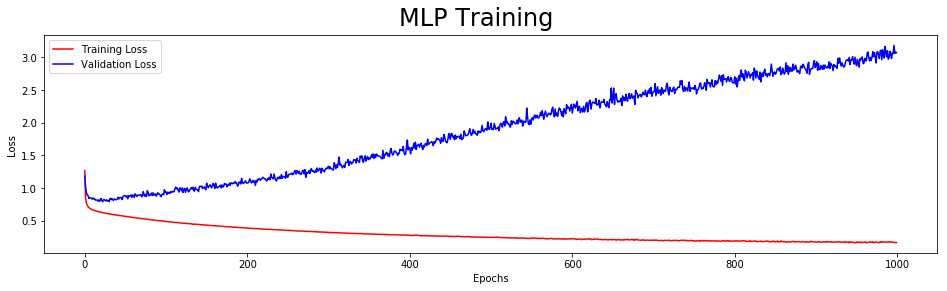

In [39]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(history.history['loss'],'r',label = 'Training Loss')
ax.plot(history.history['val_loss'],'b',label = 'Validation Loss')
#ax[1].plot(history.history['accuracy'],'r',label = 'Training Accuracy')
#ax[1].plot(history.history['val_accuracy'],'b',label = 'Validation Accuracy')
ax.legend()
#ax[1].legend()
ax.set_xlabel('Epochs')
#ax[1].set_xlabel('Epochs');
ax.set_ylabel('Loss')
#ax[1].set_ylabel('Accuracy %');
fig.suptitle('MLP Training', fontsize = 24)
plt.show()

In [40]:

train_accuracy = model.evaluate(X,y_nn)[1]
print('Training Accuracy:',train_accuracy)


17770/17770 [==============================] - 2s 91us/sample - loss: 0.7325 - acc: 0.8905
Training Accuracy: 0.89054585


Clean up the test data in a similar manner to the train data

In [41]:
columns = ['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm', 'cdm','rdm','rwb','lb','lcb','cb','rcb','rb']
df_test[columns] = df_test[columns].fillna(30)
df_test[columns] = df_test[columns].astype(int)
columns = ['dribbling','defending','physic','passing','shooting','pace']

for col in columns:
    df_test[col] = df_test[col].fillna(df_test[col].median())
df_test[columns] = df_test[columns].astype(int)
df_test['contract_valid_until'] = df_test['contract_valid_until'].fillna(df_test['contract_valid_until'].max())
df_test = df_test.fillna(0)
df_test['player_positions'] = df_test['player_positions'].str.split(',',n=1,expand=True)[0]
df_test.head()

,age,height_cm,weight_kg,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,High/High,High/Low,High/Medium,Low/High,Low/Low,Low/Medium,Medium/High,Medium/Low,Medium/Medium,bmi
0,32,170,72,94,94,95500000,RW,0,5,4,4,RW,2021.0,87,92,92,96,39,66,0.0,0.0,0.0,0.0,0.0,0.0,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89,89,89,93,93,93,93,93,93,93,93,92,87,87,87,92,68,66,66,66,68,63,52,52,52,63,0,0,0,0,0,0,0,1,0,24.913495
1,34,187,83,93,93,58500000,ST,1,5,4,5,LW,2022.0,90,93,82,89,35,78,0.0,0.0,0.0,0.0,0.0,0.0,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,0,1,0,0,0,0,0,0,0,23.735308
2,27,175,68,92,92,105500000,LW,1,5,5,5,CAM,2022.0,91,85,87,95,32,58,0.0,0.0,0.0,0.0,0.0,0.0,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84,84,84,90,89,89,89,90,90,90,90,89,82,82,82,89,66,61,61,61,66,61,46,46,46,61,0,0,1,0,0,0,0,0,0,22.204082
3,26,188,87,91,93,77500000,GK,1,3,3,1,GK,2023.0,69,54,58,64,56,66,87.0,92.0,78.0,89.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,0,0,0,0,0,0,0,0,1,24.615211
4,28,175,74,91,91,90000000,LW,1,4,4,4,LW,2024.0,91,83,86,94,35,66,0.0,0.0,0.0,0.0,0.0,0.0,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83,83,83,89,88,88,88,89,89,89,89,89,83,83,83,89,66,63,63,63,66,61,49,49,49,61,0,0,1,0,0,0,0,0,0,24.163265


In [51]:
y_test_nn = pd.get_dummies(df_test['player_positions'])
X_test = df_test.drop(['player_positions','team_position'],axis=1)
X_test = X_test[df_tst['club'].isin(clubs)]
y_test_nn = y_test_nn[df_tst['club'].isin(clubs)]
#X_test = MinMaxScaler().fit_transform(X_test)
X_tst = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_tst, index=X_test.index, columns=X_test.columns)
test_acc = model.evaluate(X_test,y_test_nn)[1]
print('Neural Network Test Accuracy: ',test_acc)

287/287 [==============================] - 0s 94us/sample - loss: 2.5331 - acc: 0.6864
Neural Network Test Accuracy:  0.68641114


The following barplot is count of each position that the model predicted vs the actual count of each position in the test data-set.

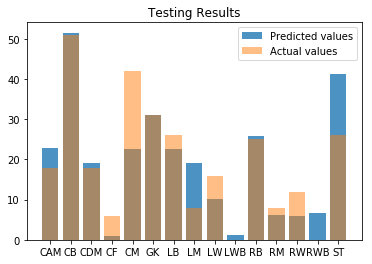

In [70]:
pos_pred = model.predict(X_test).sum(axis=0)
pos_actual = y_test_nn.sum(axis=0)
plt.bar(y_test_nn.columns,pos_pred,alpha=0.8,label='Predicted values')
plt.bar(y_test_nn.columns,pos_actual,alpha=0.5,label='Actual values')
plt.title('Testing Results')
plt.xlabel('Position')
plt.ylabel('Count')
plt.legend()
plt.show()

The following barplot is count of each position that the model predicted vs the actual count of each position in the train data-set.

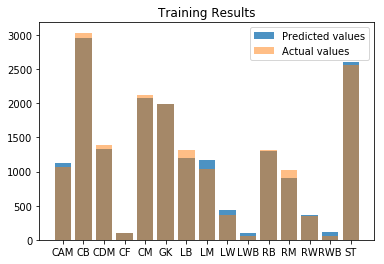

In [71]:
pos_pred = model.predict(X).sum(axis=0)
pos_actual = y_nn.sum(axis=0)
plt.bar(y_nn.columns,pos_pred,alpha=0.8,label='Predicted values')
plt.bar(y_nn.columns,pos_actual,alpha=0.5,label='Actual values')
plt.title("Training Results")
plt.xlabel('Position')
plt.ylabel('Count')
plt.legend()
plt.show()

Following is the prediction divided into three major positions - defenders, mid-players and forward players. As we can see Defenders have been predicted to play in forward positions and even strikers have been predicted to play in defender positions.

C:\Users\Joy Parikh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


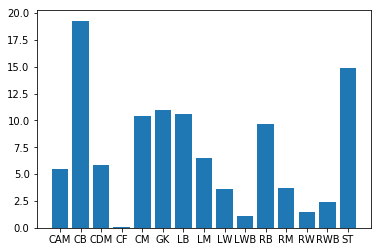

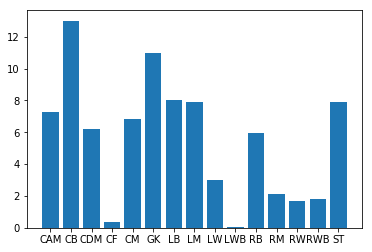

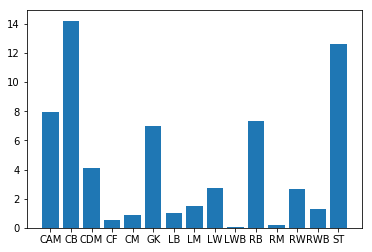

In [99]:
defenders = ['CB','CDM','LB','LWB','RB','RWB']
mid = ['CAM','CM','LM','RM']
forward = ['CF','LW','RW','ST']
y_19_actual = y_nn[df_tst['club'].isin(clubs)]
y_20_actual = y_test_nn
y_20_pre = model.predict(X_test)
y_20_pred = pd.DataFrame(y_20_pre, index=y_20_actual.index, columns=y_20_actual.columns)
pred_def = y_20_pred[(y_19_actual['CB'] == 1) | (y_19_actual['CDM'] == 1) | (y_19_actual['LB'] == 1) | (y_19_actual['LWB'] == 1)
                    | (y_19_actual['RB'] == 1) | (y_19_actual['RWB'] == 1)].sum(axis=0)
pred_mid = y_20_pred[(y_19_actual['CAM'] == 1) | (y_19_actual['CM'] == 1) | (y_19_actual['RM'] == 1) 
                    | (y_19_actual['LM'] == 1)].sum(axis=0)
pred_for = y_20_pred[(y_19_actual['CF'] == 1) | (y_19_actual['LW'] == 1) | (y_19_actual['RW'] == 1) 
                    | (y_19_actual['ST'] == 1)].sum(axis=0)
plt.figure()
plt.bar(y_nn.columns,pred_def)
plt.xlabel('Position')
plt.ylabel('Count')
plt.figure()
plt.bar(y_nn.columns,pred_mid)
plt.xlabel('Position')
plt.ylabel('Count')
plt.figure()
plt.bar(y_nn.columns,pred_for)
plt.xlabel('Position')
plt.ylabel('Count')
plt.show()
